# Tian Xu Assignment 2

This is the assignment 2 for course QMSS5074

## Prepare the data

## 1. Use Google Drive link to view a folder I shared with @columbia.edu google drive users
https://drive.google.com/drive/folders/18O-BnGOIw9ZiUwy17Uk_361xyfTF-qAN?usp=sharing
## 2. After opening this link, right click this new folder and click "Add shortcut to Drive"
This will be sure the zipfile in this folder is accessible in your personal drive folder


In [2]:
# Connect to google drive
import os
from google.colab import drive
drive.mount('/content/drive')

# content in your drive is now available via "/content/drive/My Drive"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/Untitled folder



/content/drive/MyDrive/Untitled folder


In [4]:
# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3


In [5]:
# Extracting all filenames iteratively
base_path = 'COVID-19_Radiography_Dataset'
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])


number of images for each category: [3616, 10192, 1345]


In [6]:
#Reduce number of images to first 1345 for each category
fnames[0]=fnames[0][0:1344]
fnames[1]=fnames[1][0:1344]
fnames[2]=fnames[2][0:1344]

In [7]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
from keras.preprocessing import image
import numpy as np
from PIL import Image

def preprocessor(img_path):
        img = Image.open(img_path).convert("RGB").resize((192,192)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-1.)/(255-1.) # min max transformation
        img=img.reshape((192,192,3)) # Create final shape as array with correct dimensions for Keras
        return img



#Try on single flower file (imports file and preprocesses it to data with following shape)
preprocessor('COVID-19_Radiography_Dataset/COVID/images/COVID-2273.png').shape

(192, 192, 3)

In [8]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [9]:
len(image_filepaths)

4032

### Some information about the the list of preprocessed images

In [10]:
print(len(X) ) #same number of elements as filenames
print(X.shape ) #dimensions now 192,192,3 for all images
print(X.min().round() ) #min value of every image is zero
print(X.max() ) #max value of every image is one


4032
(4032, 192, 192, 3)
-0.0
1.0


In [11]:
len(fnames[2])

1344

In [12]:
### one-hot encoding these labels to make them suitable for a machine learning model in Keras.

In [13]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1344, 1344, 1344]
4032


,COVID,NORMAL,PNEUMONIA
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
4027,0,0,1
4028,0,0,1
4029,0,0,1
4030,0,0,1


## 1 Visualize images that demonstrate when x-rays demonstrate Covid Positivity and when they do not (You can present visuals of each category in the data if you would like to.).

The following code randomly select 1 image from each category, and labeled the images.

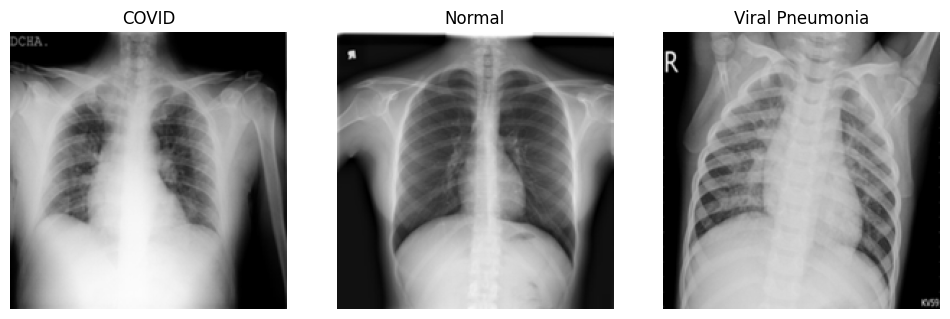

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

# Function to preprocess and return a random image from a given category
def get_random_image(category_index):
    category_images = fnames[category_index]
    random_image_path = random.choice(category_images)
    return preprocessor(random_image_path)

# Getting one random image from each category
im1 = get_random_image(0)  # COVID
im2 = get_random_image(1)  # Normal
im3 = get_random_image(2)  # Viral Pneumonia

# Creating labels for each category
labels = ['COVID', 'Normal', 'Viral Pneumonia']

# Creating a 1x3 grid for images
fig = plt.figure(figsize=(12, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.5)

# Displaying each image along with its category label
for ax, im, label in zip(grid, [im1, im2, im3], labels):
    ax.imshow(im)
    ax.set_title(label)
    ax.axis('off')  # Hiding axes for a cleaner look

plt.show()


## 2 Discuss the dataset in general terms and describe why building a predictive model using this data might be practically useful.  Who could benefit from a model like this? Explain.

This dataset contains X-ray images categorized into COVID-19, Normal, and Viral Pneumonia, which is essential for building predictive models for automated disease diagnosis. Utilizing this data to develop a model can enhance the accuracy of diagnosing COVID-19 and other respiratory illnesses, which is crucial in healthcare emergencies. Healthcare institutions could benefit from such a model, which would aid in managing and prioritizing patient care effectively and efficiently.



## 3 Run at least three prediction models to try to predict x-ray images wel

In [15]:
# ======Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)=======================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.32, random_state = 1987)


X_test.shape, y_test.shape

((1291, 192, 192, 3), (1291, 3))

In [16]:
#Clear objects from memory
del(X)
del(y)
del(preprocessed_image_data)

In [17]:
#Save data to be able to reload quickly if memory crashes or if you run Runtime>Restart Runtime
import pickle

# Open a file and use dump()
with open('X_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_train, file)

#Save data
import pickle

# Open a file and use dump()
with open('X_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_test, file)

#Save data
import pickle

# Open a file and use dump()
with open('y_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_train, file)


# Open a file and use dump()
with open('y_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_test, file)

In [18]:
#If you run out of Colab memory restart runtime, reload data and try again
import pickle

# Open the file in binary mode
with open('X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

### Model 1 CNN

In [19]:
import tensorflow as tf

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  # Fitting the CNN to the Training set
  model.fit(X_train, y_train,
                    epochs = 1, verbose=1,validation_split=.2) #, callbacks=[red_lr]) for callback that automatically adjusts lr

69/69 [==============================] - 21s 67ms/step - loss: 0.8829 - accuracy: 0.5511 - val_loss: 0.9085 - val_accuracy: 0.6521


In [20]:
model.save("model1.h5", save_format="h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 32)      1056      
                                                                 
 max_pooling2d (MaxPooling2  (None, 96, 96, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 64)        4160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                   

### Model 2: VGG16 Model

In [22]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load VGG16 model + higher level layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(192, 192, 3))

# Freeze the layers in base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)  # new FC layer, random init
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)  # new softmax layer

# Compile model
model2 = Model(inputs=base_model.input, outputs=predictions)
optimizer = Adam(lr=0.0001)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model2.fit(X_train, y_train, epochs=10, validation_split=0.2)


Epoch 1/10
69/69 [==============================] - 8s 67ms/step - loss: 0.8257 - accuracy: 0.6218 - val_loss: 0.5843 - val_accuracy: 0.7723
Epoch 2/10
69/69 [==============================] - 3s 48ms/step - loss: 0.5389 - accuracy: 0.7924 - val_loss: 0.4777 - val_accuracy: 0.7978
Epoch 3/10
69/69 [==============================] - 3s 48ms/step - loss: 0.4424 - accuracy: 0.8294 - val_loss: 0.3713 - val_accuracy: 0.8652
Epoch 4/10
69/69 [==============================] - 3s 45ms/step - loss: 0.3866 - accuracy: 0.8572 - val_loss: 0.3380 - val_accuracy: 0.8816
Epoch 5/10
69/69 [==============================] - 3s 45ms/step - loss: 0.3448 - accuracy: 0.8682 - val_loss: 0.2991 - val_accuracy: 0.8907
Epoch 6/10
69/69 [==============================] - 3s 46ms/step - loss: 0.3367 - accuracy: 0.8677 - val_loss: 0.3169 - val_accuracy: 0.8707
Epoch 7/10
69/69 [==============================] - 3s 47ms/step - loss: 0.3123 - accuracy: 0.8818 - val_loss: 0.2659 - val_accuracy: 0.9016
Epoch 8/10
69

In [23]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

In [24]:
model2.save("model2.h5", save_format="h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Model 3


In [25]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load VGG16 as the base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(192, 192, 3))

# Make sure the base model layers are not trainable
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Add layers to the model
model3 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

# Compile the model
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model3.fit(X_train, y_train, epochs=10, validation_split=0.2)


Epoch 1/10
69/69 [==============================] - 15s 126ms/step - loss: 1.1842 - accuracy: 0.3116 - val_loss: 1.0983 - val_accuracy: 0.3388
Epoch 2/10
69/69 [==============================] - 8s 109ms/step - loss: 1.0992 - accuracy: 0.3403 - val_loss: 1.0978 - val_accuracy: 0.3206
Epoch 3/10
69/69 [==============================] - 7s 107ms/step - loss: 1.1052 - accuracy: 0.3481 - val_loss: 1.0984 - val_accuracy: 0.3388
Epoch 4/10
69/69 [==============================] - 8s 110ms/step - loss: 1.1556 - accuracy: 0.3271 - val_loss: 1.0998 - val_accuracy: 0.3206
Epoch 5/10
69/69 [==============================] - 7s 105ms/step - loss: 1.0990 - accuracy: 0.3225 - val_loss: 1.0994 - val_accuracy: 0.3206
Epoch 6/10
69/69 [==============================] - 8s 111ms/step - loss: 1.0987 - accuracy: 0.3371 - val_loss: 1.0988 - val_accuracy: 0.3206
Epoch 7/10
69/69 [==============================] - 7s 107ms/step - loss: 1.0986 - accuracy: 0.3394 - val_loss: 1.0988 - val_accuracy: 0.3206
Epoch

In [26]:
model3.save("model3.h5", save_format="h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Discuss which models performed better and point out relevant hyper-parameter values for successful models.

The VGG16 Transfer Learning Model (Model 2) performs the best among the three, starting at 63% and improves significantly over epochs. The validation accuracy also improves, reaching up to ~91%, indicating that the model is generalizing well to new data.
For Hyper-parameters, the model uses VGG16 as a base, leveraging pre-trained weights, which is a crucial success factor. Trained for 10 epochs, which seems sufficient for this model to learn and improve accuracy.

###  submit your best three models to the leader board for the Covid X-ray Diagnostic AI Model Share competition.

#### model 1

In [27]:
# Reload model and data
import tensorflow as tf
model = tf.keras.models.load_model('model1.h5',compile=True)
model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 32)      1056      
                                                                 
 max_pooling2d (MaxPooling2  (None, 96, 96, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 64)        4160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                   

In [28]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle

# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

41/41 [==============================] - 1s 23ms/step


In [29]:
! pip install aimodelshare --upgrade

In [30]:
apiurl='https://w2zzwqfobi.execute-api.us-east-2.amazonaws.com/prod/m'

from aimodelshare.playground import ModelPlayground
experiment=ModelPlayground(playground_url=apiurl, task_type="classification")

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

Modelshare.ai Username:··········
Modelshare.ai Password:··········
Modelshare.ai login credentials set successfully.


In [37]:
# Submit Model 1 to Competition Leaderboard
experiment.submit_model(model= model,
                                 preprocessor = None,
                                 prediction_submission=prediction_labels)

Timeout: Model to ONNX conversion is taking longer than expected. This can be the case for big models.
Do you want to keep trying (1) or submit predictions only (2)? 2

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 
Your model has been submitted to experiment as model version 15.

Visit your Model Playground Page for more.
https://www.modelshare.ai/detail/model:3867


#### model2

In [38]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle

# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

prediction_column_index=model2.predict(X_test).argmax(axis=1)

# extract correct prediction labels
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

41/41 [==============================] - 2s 34ms/step


In [39]:
# Submit Model 1 to Competition Leaderboard
experiment.submit_model(model= model2,
                                 preprocessor = None,
                                 prediction_submission=prediction_labels)

Timeout: Model to ONNX conversion is taking longer than expected. This can be the case for big models.
Do you want to keep trying (1) or submit predictions only (2)? 2

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 
Your model has been submitted to experiment as model version 16.

Visit your Model Playground Page for more.
https://www.modelshare.ai/detail/model:3867


#### Model3

In [40]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle

# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

prediction_column_index=model3.predict(X_test).argmax(axis=1)

# extract correct prediction labels
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

41/41 [==============================] - 1s 31ms/step


In [41]:
# Submit Model 3 to Competition Leaderboard
experiment.submit_model(model= model3,
                                 preprocessor = None,
                                 prediction_submission=prediction_labels)

Timeout: Model to ONNX conversion is taking longer than expected. This can be the case for big models.
Do you want to keep trying (1) or submit predictions only (2)? 2

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 
Your model has been submitted to experiment as model version 17.

Visit your Model Playground Page for more.
https://www.modelshare.ai/detail/model:3867


In [42]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

,accuracy,f1_score,precision,recall,ml_framework,model_type,username,version
0,90.32%,90.22%,90.36%,90.31%,unknown,unknown,xutian0117,15
1,90.32%,90.22%,90.36%,90.31%,unknown,unknown,xutian0117,14
2,86.37%,85.93%,87.61%,86.36%,unknown,unknown,xutian0117,16
3,75.76%,75.79%,76.52%,75.76%,unknown,unknown,xutian0117,12
4,74.28%,74.15%,76.97%,74.29%,unknown,unknown,xutian0117,13
5,73.04%,71.53%,75.72%,73.03%,unknown,unknown,jiananyang81,9
6,73.04%,71.53%,75.72%,73.03%,unknown,unknown,jiananyang81,7
7,73.04%,71.53%,75.72%,73.03%,unknown,unknown,jiananyang81,8
8,73.04%,71.53%,75.72%,73.03%,unknown,unknown,jiananyang81,10
9,72.50%,71.79%,71.89%,72.49%,unknown,unknown,xutian0117,11


## Try to use augmented data to rerun at least one model and submit it to the leaderboard.

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, Model
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(192, 192, 3))
x = layers.Flatten()(base_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(3, activation='softmax')(x)

model_aug = Model(base_model.input, x)
model_aug.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_aug.fit(X_train, y_train, epochs=10, validation_split=0.2,steps_per_epoch=len(X_train) / 32)


Epoch 1/10
85/85 [==============================] - 16s 102ms/step - loss: 1.3040 - accuracy: 0.3354 - val_loss: 1.0878 - val_accuracy: 0.4171
Epoch 2/10
85/85 [==============================] - 8s 99ms/step - loss: 1.0681 - accuracy: 0.4360 - val_loss: 0.8807 - val_accuracy: 0.6412
Epoch 3/10
85/85 [==============================] - 8s 96ms/step - loss: 0.7882 - accuracy: 0.6646 - val_loss: 0.8141 - val_accuracy: 0.5592
Epoch 4/10
85/85 [==============================] - 9s 100ms/step - loss: 0.5347 - accuracy: 0.7989 - val_loss: 0.4241 - val_accuracy: 0.8233
Epoch 5/10
85/85 [==============================] - 9s 100ms/step - loss: 0.4317 - accuracy: 0.8404 - val_loss: 0.3516 - val_accuracy: 0.8543
Epoch 6/10
85/85 [==============================] - 9s 100ms/step - loss: 0.4063 - accuracy: 0.8363 - val_loss: 0.3435 - val_accuracy: 0.8670
Epoch 7/10
85/85 [==============================] - 8s 95ms/step - loss: 0.3391 - accuracy: 0.8742 - val_loss: 0.2968 - val_accuracy: 0.8852
Epoch 8/

85/85 [==============================] - 8s 88ms/step - loss: 0.2575 - accuracy: 0.9030 - val_loss: 0.2745 - val_accuracy: 0.9016


### Discusse the Results

Model 4 increased the diversity and amount of training data, helping the model generalize better, with training accuracy ~90.30% and validation accuracy ~90.16%

In [34]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle

# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

prediction_column_index=model_aug.predict(X_test).argmax(axis=1)

# extract correct prediction labels
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

41/41 [==============================] - 3s 62ms/step


In [36]:
# Submit Model 3 to Competition Leaderboard
experiment.submit_model(model= model_aug,
                                 preprocessor = None,
                                 prediction_submission=prediction_labels)

Timeout: Model to ONNX conversion is taking longer than expected. This can be the case for big models.
Do you want to keep trying (1) or submit predictions only (2)? 2

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 
Your model has been submitted to experiment as model version 14.

Visit your Model Playground Page for more.
https://www.modelshare.ai/detail/model:3867


In [43]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

,accuracy,f1_score,precision,recall,ml_framework,model_type,username,version
0,90.32%,90.22%,90.36%,90.31%,unknown,unknown,xutian0117,15
1,90.32%,90.22%,90.36%,90.31%,unknown,unknown,xutian0117,14
2,86.37%,85.93%,87.61%,86.36%,unknown,unknown,xutian0117,16
3,75.76%,75.79%,76.52%,75.76%,unknown,unknown,xutian0117,12
4,74.28%,74.15%,76.97%,74.29%,unknown,unknown,xutian0117,13
5,73.04%,71.53%,75.72%,73.03%,unknown,unknown,jiananyang81,9
6,73.04%,71.53%,75.72%,73.03%,unknown,unknown,jiananyang81,7
7,73.04%,71.53%,75.72%,73.03%,unknown,unknown,jiananyang81,8
8,73.04%,71.53%,75.72%,73.03%,unknown,unknown,jiananyang81,10
9,72.50%,71.79%,71.89%,72.49%,unknown,unknown,xutian0117,11


## Discuss which models you tried and which models performed better and point out relevant hyper-parameter values for successful models.



The VGG16 model with Transfer Learning (Model 2) and Data Augmentation (Model 4) yielded the best performances, with validation accuracies of ~91.26% and ~90.16% respectively. The success of these models can be attributed to the utilization of the pre-trained VGG16 model, allowing them to benefit from previously learned image features. Transfer learning and data augmentation strategies further enhanced their generalization capabilities, contributing to higher accuracy. Key hyperparameters that worked well include 10 epochs and applying various data augmentations (rotation, width shift, height shift, shear, zoom, and horizontal flip) in Model 4.